In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, auc, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency, spearmanr, pearsonr
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)

In [2]:
df = pd.read_csv('../rotterdam.csv')
df = df.dropna()

## Variable Selection Rationale

**Excluded Variables:**
- **`year`**: Time of surgery (enrollment year) is excluded because we're building a predictive model based on patient characteristics and tumor biology, not temporal trends. Including year would reduce external validity and generalizability to future patients.
- **`hospital_id` (pid)**: Patient/hospital identifiers are excluded as they don't represent clinical features. These are administrative codes with no biological or prognostic meaning for recurrence prediction.
- **`meno` (menopausal status)**: Excluded based on preliminary analysis showing no significant association with recurrence (p=0.332 in univariate tests). Age captures similar information more continuously.

**Included Variables:**
- **Clinical/pathological features**: age, tumor grade, tumor size, lymph node involvement
- **Biological markers**: ER (estrogen receptor), PGR (progesterone receptor) levels

In [3]:
CUTOFF_DAYS = 3650 # 5 years in days

# Recurrence is defined as early recurrence (within 5 years)
df['target'] = np.where((df['recur'] == 1) & (df['rtime'] >= CUTOFF_DAYS), 1, 0)

# Filter out patients with no recurrence and less than 5 years of follow-up (censored)
valid_mask = (df['nodes'] == 0) & (df['er'] > 10) & ((df['target'] == 1) | ((df['target'] == 0) & (df['rtime'] < CUTOFF_DAYS)))
df_clean = df[valid_mask].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after filtering (follow-up >= 5y): {df_clean.shape}")

summary = pd.DataFrame({
    'Count': df_clean['target'].value_counts(),
    'Proportion': df_clean['target'].value_counts(normalize=True).round(3)
})
print("\nRecurrence summary:\n")
print(summary)

Original shape: (2982, 17)
Shape after filtering (follow-up >= 5y): (918, 17)

Recurrence summary:

        Count  Proportion
target                   
0         844       0.919
1          74       0.081


In [4]:
df_clean['er_log'] = np.log1p(df_clean['er'])
df_clean['pgr_log'] = np.log1p(df_clean['pgr'])

# categorize ER and PGR into binary groups (0: <10, 1: >=10)
df_clean['er_cat'] = np.where(df_clean['er'] >= 10, 1, 0)
df_clean['pgr_cat'] = np.where(df_clean['pgr'] >= 10, 1, 0)

# grade: already ordinal (2 < 3)
# size: <=20, 20-50, >50 → map to 0, 1, 2
size_map = {'<=20': 0, '20-50': 1, '>50': 2}
df_clean['size_ord'] = df_clean['size'].map(size_map)

# age: binned into decades: (<40:0, 40-49:1, 50-59:2, 60-69:3, 70+:4)
age_bins = [0, 39, 49, 59, 69, np.inf]
age_labels = [0, 1, 2, 3, 4]
df_clean['age_bin'] = pd.cut(df_clean['age'], bins=age_bins, labels=age_labels, right=True).astype(int)

df_clean['age_x_grade'] = df_clean['age'] * df_clean['grade']
df_clean['size_x_pgr'] = df_clean['size'].map({'<=20': 0, '20-50': 1, '>50': 2}) * df_clean['pgr_log']
df_clean['size_x_er'] = df_clean['size'].map({'<=20': 0, '20-50': 1, '>50': 2}) * df_clean['er_log']

num_features = ['age', 'pgr_log', 'er_log', 'pgr', 'er', 'age_x_grade', 'size_x_pgr', 'size_x_er']
ordinal_features = ['grade', 'size_ord', 'age_bin']  # Treat as ordinal
cat_features = ['er_cat', 'pgr_cat', 'hormon', 'chemo']  # Keep nodes_cat as nominal categorical

X = df_clean[num_features + ordinal_features + cat_features]
y = df_clean['target']

# Statistical Tests on Features

**Tests performed:**
- **Mann-Whitney U test (non-parametric)**: Compares distributions when normality assumption is violated
- **Chi-Square test**

In [5]:
# Separate features by type
cont_vars = ['age', 'er', 'pgr', 'er_log', 'pgr_log', 'age_x_grade', 'size_x_pgr', 'size_x_er', 'grade']
cat_vars = ['size', 'meno', 'er_cat', 'pgr_cat', 'size_ord', 'age_bin', 'hormon', 'chemo']

# t-test is for parametric continuous variables, so we use Mann-Whitney U test for non-parametric continuous variables

print("\n--- Continuous Variables (Mann-Whitney U Test) ---")
for col in cont_vars:
    # Compare distributions between Recurrence (1) and No-Recurrence (0)
    stat, p = mannwhitneyu(df_clean[df_clean['target']==1][col], df_clean[df_clean['target']==0][col])
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")

print("\n--- Categorical Variables (Chi-Square Test) ---")
for col in cat_vars:
    # Check dependency between category and target
    ct = pd.crosstab(df_clean[col], df_clean['target'])
    stat, p, _, _ = chi2_contingency(ct)
    print(f"{col.upper()}: p={p:.4f} {'(Significant)' if p<0.05 else ''}")


--- Continuous Variables (Mann-Whitney U Test) ---
AGE: p=0.0356 (Significant)
ER: p=0.0203 (Significant)
PGR: p=0.3833 
ER_LOG: p=0.0203 (Significant)
PGR_LOG: p=0.3833 
AGE_X_GRADE: p=0.0446 (Significant)
SIZE_X_PGR: p=0.7135 
SIZE_X_ER: p=0.8632 
GRADE: p=0.6089 

--- Categorical Variables (Chi-Square Test) ---
SIZE: p=0.8798 
MENO: p=0.1838 
ER_CAT: p=1.0000 
PGR_CAT: p=1.0000 
SIZE_ORD: p=0.8798 
AGE_BIN: p=0.0270 (Significant)
HORMON: p=1.0000 
CHEMO: p=1.0000 


## 1. Descriptive Statistics by Recurrence Status

In [6]:
print("\n" + "="*80)
print("NUMERICAL VARIABLES - Descriptive Statistics")
print("="*80)

numerical_vars = ['age', 'er', 'pgr', 'er_log', 'pgr_log', 'age_x_grade', 'size_x_pgr', 'size_x_er', 'grade']

desc_stats_num = []
for var in numerical_vars:
    recur_yes = df_clean[y == 1][var]
    recur_no = df_clean[y == 0][var]
    
    desc_stats_num.append({
        'Variable': var,
        'No Recur (Mean±SD)': f"{recur_no.mean():.2f}±{recur_no.std():.2f}",
        'Recurrence (Mean±SD)': f"{recur_yes.mean():.2f}±{recur_yes.std():.2f}",
        'No Recur (Median[IQR])': f"{recur_no.median():.2f}[{recur_no.quantile(0.25):.2f}-{recur_no.quantile(0.75):.2f}]",
        'Recurrence (Median[IQR])': f"{recur_yes.median():.2f}[{recur_yes.quantile(0.25):.2f}-{recur_yes.quantile(0.75):.2f}]"
    })

desc_stats_num_df = pd.DataFrame(desc_stats_num)
print(desc_stats_num_df.to_string(index=False))

print("\n" + "="*80)
print("CATEGORICAL VARIABLES - Descriptive Statistics")
print("="*80)

categorical_vars = ['grade', 'size', 'meno', 'er_cat', 'pgr_cat', 'size_ord', 'age_bin', 'hormon', 'chemo']

for var in categorical_vars:
    ct = pd.crosstab(df_clean[var], y, margins=False)
    prop = pd.crosstab(df_clean[var], y, normalize='index') * 100
    
    print(f"\n{var.upper()}:")
    print("\nRow Percentages:")
    print(prop.round(1).to_string())



NUMERICAL VARIABLES - Descriptive Statistics
   Variable No Recur (Mean±SD) Recurrence (Mean±SD) No Recur (Median[IQR]) Recurrence (Median[IQR])
        age        55.81±12.95          52.23±11.11     55.00[46.00-66.00]       52.50[45.00-60.00]
         er      230.66±285.93        145.43±176.23   122.00[45.00-303.50]      77.00[41.50-178.75]
        pgr      212.27±297.86        155.54±184.26   101.00[22.00-290.50]      87.50[30.50-186.50]
     er_log          4.78±1.22            4.45±1.03        4.81[3.83-5.72]          4.36[3.75-5.19]
    pgr_log          4.19±1.95            4.00±1.92        4.62[3.14-5.68]          4.48[3.45-5.23]
age_x_grade       149.64±44.54         138.77±41.38  142.00[114.00-186.00]    133.00[105.25-174.00]
 size_x_pgr          1.59±2.60            1.68±2.58        0.00[0.00-3.58]          0.00[0.00-3.93]
  size_x_er          1.86±2.72            1.88±2.58        0.00[0.00-4.09]          0.00[0.00-3.84]
      grade          2.68±0.47            2.65±0.48   

## 4. Univariate Logistic Regression Analysis

Tests the association between each feature and recurrence outcome.

In [7]:
print("\n" + "="*80)
print("UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)")
print("="*80)

logistic_results = []

# Numerical features
for var in numerical_vars:
    try:
        X_temp = df_clean[[var]].copy()
        X_temp = sm.add_constant(X_temp)
        
        model = sm.Logit(y, X_temp).fit(disp=0)
        
        coef = model.params[var]
        or_val = np.exp(coef)
        pval = model.pvalues[var]
        ci_lower = np.exp(coef - 1.96 * model.bse[var])
        ci_upper = np.exp(coef + 1.96 * model.bse[var])
        
        logistic_results.append({
            'Variable': var,
            'Coeff': f"{coef:.4f}",
            'OR': f"{or_val:.4f}",
            '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
            'P-value': f"{pval:.4f}",
            'Sig': '***' if pval < 0.05 else ''
        })
    except Exception as e:
        print(f"Skipping {var} (num): {e}")
        continue

# Categorical features (one-hot with reference)
for var in categorical_vars:
    try:
        dummies = pd.get_dummies(df_clean[var], prefix=var, drop_first=True, dtype=float)
        if dummies.empty:
            continue
        X_temp = sm.add_constant(dummies)
        model = sm.Logit(y.astype(float), X_temp).fit(disp=0)
        for col in dummies.columns:
            coef = model.params[col]
            or_val = np.exp(coef)
            pval = model.pvalues[col]
            ci_lower = np.exp(coef - 1.96 * model.bse[col])
            ci_upper = np.exp(coef + 1.96 * model.bse[col])
            level = col.replace(f"{var}_", "")
            logistic_results.append({
                'Variable': f"{var}={level}",
                'Coeff': f"{coef:.4f}",
                'OR': f"{or_val:.4f}",
                '95% CI': f"({ci_lower:.4f}, {ci_upper:.4f})",
                'P-value': f"{pval:.4f}",
                'Sig': '***' if pval < 0.05 else ''
            })
    except Exception as e:
        print(f"Skipping {var} (cat): {e}")
        continue

logistic_df = pd.DataFrame(logistic_results)
print(logistic_df.to_string(index=False))


UNIVARIATE LOGISTIC REGRESSION (Odds Ratios)
   Variable   Coeff     OR           95% CI P-value Sig
        age -0.0223 0.9780 (0.9594, 0.9968)  0.0222 ***
         er -0.0017 0.9983 (0.9969, 0.9996)  0.0112 ***
        pgr -0.0009 0.9991 (0.9980, 1.0002)  0.1066    
     er_log -0.2286 0.7956 (0.6509, 0.9726)  0.0257 ***
    pgr_log -0.0490 0.9522 (0.8456, 1.0723)  0.4190    
age_x_grade -0.0057 0.9943 (0.9887, 0.9999)  0.0442 ***
 size_x_pgr  0.0125 1.0126 (0.9257, 1.1077)  0.7841    
  size_x_er  0.0025 1.0025 (0.9185, 1.0941)  0.9560    
      grade -0.1302 0.8779 (0.5332, 1.4454)  0.6087    
    grade=3 -0.1302 0.8779 (0.5332, 1.4454)  0.6087    
  size=<=20 -0.1281 0.8798 (0.5345, 1.4481)  0.6145    
   size=>50 -0.0448 0.9562 (0.2133, 4.2873)  0.9534    
     meno=1 -0.3511 0.7039 (0.4372, 1.1332)  0.1484    
  pgr_cat=1 -0.0437 0.9572 (0.5123, 1.7886)  0.8909    
 size_ord=1  0.1281 1.1366 (0.6906, 1.8708)  0.6145    
 size_ord=2  0.0833 1.0869 (0.2476, 4.7706)  0.9121    
  

## 5. Correlation Analysis

Spearman correlation for examining relationships between continuous variables.

In [8]:
print("\n" + "="*80)
print("CORRELATION WITH RECURRENCE OUTCOME")
print("="*80)

correlation_results = []

for var in numerical_vars:
    spear_corr, spear_pval = spearmanr(df_clean[var].dropna(), y[df_clean[var].notna()])
    
    correlation_results.append({
        'Variable': var,
        'Spearman ρ': f"{spear_corr:.4f}",
        'Spearman p-val': f"{spear_pval:.4f}",
    })

corr_df = pd.DataFrame(correlation_results)
print(corr_df.to_string(index=False))



CORRELATION WITH RECURRENCE OUTCOME
   Variable Spearman ρ Spearman p-val
        age    -0.0694         0.0355
         er    -0.0766         0.0202
        pgr    -0.0288         0.3835
     er_log    -0.0766         0.0202
    pgr_log    -0.0288         0.3835
age_x_grade    -0.0663         0.0445
 size_x_pgr     0.0121         0.7135
  size_x_er     0.0057         0.8631
      grade    -0.0169         0.6090


## 6. Multicollinearity Check (VIF Analysis)

In [9]:
print("\n" + "="*80)
print("VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check")
print("="*80)

# Calculate VIF for numerical features
X_vif = df_clean[numerical_vars].copy()
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = numerical_vars
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i+1) for i in range(len(numerical_vars))]

print(vif_data.to_string(index=False))


VARIANCE INFLATION FACTOR (VIF) - Multicollinearity Check
   Variable       VIF
        age 36.161768
         er  3.185340
        pgr  2.006561
     er_log  3.567987
    pgr_log  2.535348
age_x_grade 57.310725
 size_x_pgr  5.809999
  size_x_er  5.614484
      grade 20.409907


## KEY FINDINGS:

1. AGE
   - NOT significantly associated with recurrence (p=0.998)
   - Mean age similar in both groups (~54.5 years)
   - Not a significant predictor

2. LYMPH NODES
   - Continuous log scale: *** highly significant (p<0.001); OR = 3.04 (95% CI: 2.73-3.37)
   - Categorical groups (ref = 0 nodes):
       * 1-3 nodes: OR = 2.13 (95% CI: 1.68-2.70)
       * 4-9 nodes: OR = 7.33 (95% CI: 5.68-9.46)
       * 10+ nodes: OR = 19.72 (95% CI: 13.91-27.94)
   - Recurrence proportions rise steadily across categories (0: 16.4%, 1-3: 29.4%, 4-9: 58.9%, 10+: 79.4%)
   - Strong positive correlation with recurrence (ρ=0.45)

3. ESTROGEN RECEPTORS (er_log)
   - *** Significant (p<0.01)
   - Higher ER levels = LOWER recurrence risk
   - OR = 0.94 (95% CI: 0.90-0.98)
   - Weak negative correlation (ρ=-0.06)

4. PROGESTERONE RECEPTORS (pgr_log)
   - *** Highly significant (p<0.001)
   - Higher PGR levels = LOWER recurrence risk
   - OR = 0.88 (95% CI: 0.85-0.92)
   - Weak-moderate negative correlation (ρ=-0.14)

5. TUMOR GRADE
   - *** Highly significant (p<0.001)
   - Grade 3 vs Grade 2: OR = 2.61 (95% CI: 2.09-3.26)
   - Grade 3 recurrence: 38.4% vs Grade 2: 19.3%

6. TUMOR SIZE
   - *** Highly significant (p<0.001)
   - Size >50mm: 66.5% recurrence (highest risk)
   - Size ≤20mm: 18.5% recurrence (lowest risk)
   - Size 20-50mm: 41.4% recurrence

7. MENOPAUSAL STATUS
   - NOT significant (p=0.332)
   - Similar recurrence rates: 32.2% (premenopausal) vs 34.2% (postmenopausal)

MULTICOLLINEARITY:
   - All VIF < 2, no multicollinearity issues
   - Features are independent

CLINICAL SIGNIFICANCE:
   - Lymph node burden is the strongest driver; risk escalates sharply with higher node categories
   - Tumor size and grade remain key risk factors
   - Higher ER/PGR levels are protective
   - Age and menopausal status are not meaningful predictors in this dataset

In [38]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

# --- Feature Selection Functions (NO internal CV) ---

def forward_selection(X_train, y_train):
    """Perform forward selection on training data without internal CV"""
    sfs_forward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='forward',
        scoring='roc_auc',
        cv=2,  # Minimal internal CV just for selection
        n_jobs=-1
    )
    sfs_forward.fit(X_train, y_train)
    fwd_idx = sfs_forward.get_support()
    return fwd_idx

def backward_elimination(X_train, y_train):
    """Perform backward elimination on training data without internal CV"""
    sfs_backward = SequentialFeatureSelector(
        LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234),
        direction='backward',
        scoring='roc_auc',
        cv=2,  # Minimal internal CV just for selection
        n_jobs=-1
    )
    sfs_backward.fit(X_train, y_train)
    bwd_idx = sfs_backward.get_support()
    return bwd_idx

def best_subset_selection(X_train, y_train, max_features=8):
    """Perform best subset selection using exhaustive search"""
    from itertools import combinations
    feature_list = list(range(X_train.shape[1]))
    best_score = -np.inf
    best_idx = []
    
    for k in range(1, min(max_features, len(feature_list)) + 1):
        for combo in combinations(feature_list, k):
            X_subset = X_train[:, combo]
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
            model.fit(X_subset, y_train)
            y_prob = model.predict_proba(X_subset)[:, 1]
            score = roc_auc_score(y_train, y_prob)
            
            if score > best_score:
                best_score = score
                best_idx = list(combo)
    
    # Convert to boolean mask
    mask = np.zeros(X_train.shape[1], dtype=bool)
    mask[best_idx] = True
    return mask

In [51]:

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Define Features
numerical = ['age_x_grade', 'size_x_pgr', 'er_log']
categorical = ['hormon', 'chemo']

# 2. Define Pipelines
num_pipe = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='if_binary'))
])

# 3. Combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, numerical),
        ('cat', cat_pipe, categorical)
    ],
    verbose_feature_names_out=False
)

In [53]:
# --- Prepare Data and Preprocess (NO TRAIN/TEST SPLIT YET) ---
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Prepare Data with selected features
X = df_clean[['age_x_grade', 'size_x_pgr', 'er_log', 'hormon', 'chemo']]
y = df_clean['target']

# Preprocess FULL dataset (will be split inside CV)
X_proc = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

# Convert to DataFrame for easier handling
X_df = pd.DataFrame(X_proc, columns=feature_names, index=X.index)

print(f"Full dataset size: {X_df.shape[0]}")
print(f"Processed features: {', '.join(feature_names)}")
print(f"Total features: {len(feature_names)}")
print(f"Class distribution: {y.value_counts().sort_index().to_dict()}")
print()

# --- UNDERSAMPLING FUNCTION (to be applied in each CV fold) ---
def undersample_data(X_fold, y_fold, random_state=None):
    """
    Undersample the majority class to match minority class size.
    Returns undersampled X and y.
    """
    # Separate majority and minority classes
    X_majority = X_fold[y_fold == 0]
    X_minority = X_fold[y_fold == 1]
    y_majority = y_fold[y_fold == 0]
    y_minority = y_fold[y_fold == 1]
    
    # Undersample majority class
    X_majority_undersampled, y_majority_undersampled = resample(
        X_majority,
        y_majority,
        n_samples=len(X_minority),
        random_state=random_state,
        replace=False
    )
    
    # Combine and shuffle
    X_balanced = pd.concat([X_majority_undersampled, X_minority])
    y_balanced = pd.concat([y_majority_undersampled, y_minority])
    
    shuffle_idx = np.random.RandomState(random_state).permutation(len(X_balanced))
    X_balanced = X_balanced.iloc[shuffle_idx].reset_index(drop=True)
    y_balanced = y_balanced.iloc[shuffle_idx].reset_index(drop=True)
    
    return X_balanced, y_balanced

Full dataset size: 918
Processed features: age_x_grade, size_x_pgr, er_log, hormon_0, chemo_0
Total features: 5
Class distribution: {0: 844, 1: 74}



In [56]:
# --- K-FOLD CROSS-VALIDATION WITH UNDERSAMPLING AND FEATURE SELECTION ---
import time
from itertools import combinations
from collections import defaultdict

print("=" * 80)
print("K-FOLD CROSS-VALIDATION WITH UNDERSAMPLING + FEATURE SELECTION")
print("=" * 80 + "\n")

# Setup K-fold CV
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1234)

# Storage for results across folds
fold_results = {
    'forward': defaultdict(list),
    'backward': defaultdict(list),
    'best_subset': defaultdict(list)
}

feature_counts = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

selected_features_per_fold = {
    'forward': [],
    'backward': [],
    'best_subset': []
}

print(f"Performing {n_folds}-Fold Cross-Validation...\n")
print("Workflow per fold:")
print("  1. Split data into train/validation")
print("  2. Undersample training data (balance classes)")
print("  3. Perform feature selection on balanced data")
print("  4. Train and evaluate model\n")

# Perform K-fold CV
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_df, y), 1):
    print(f"Fold {fold_idx}/{n_folds}...")
    
    # Split data for this fold
    X_fold_train_orig = X_df.iloc[train_idx]
    y_fold_train_orig = y.iloc[train_idx]
    X_fold_val = X_df.iloc[val_idx]
    y_fold_val = y.iloc[val_idx]
    
    # Display original class distribution
    train_dist = y_fold_train_orig.value_counts().sort_index()
    print(f"  Original train distribution: No-Recur={train_dist[0]}, Recur={train_dist[1]} (ratio={train_dist[0]/train_dist[1]:.2f}:1)")
    
    # --- UNDERSAMPLE TRAINING DATA IN THIS FOLD ---
    X_fold_train_df, y_fold_train = undersample_data(
        X_fold_train_orig, 
        y_fold_train_orig, 
        random_state=1234 + fold_idx  # Different seed per fold
    )
    
    # Convert to numpy for feature selection
    X_fold_train = X_fold_train_df.values
    y_fold_train = y_fold_train.values
    X_fold_val_np = X_fold_val.values
    y_fold_val_np = y_fold_val.values
    
    # Display undersampled class distribution
    train_dist_balanced = pd.Series(y_fold_train).value_counts().sort_index()
    print(f"  Undersampled train: No-Recur={train_dist_balanced[0]}, Recur={train_dist_balanced[1]} (ratio={train_dist_balanced[0]/train_dist_balanced[1]:.2f}:1)")

    
    # --- FORWARD SELECTION ---
    try:
        fwd_mask = forward_selection(X_fold_train, y_fold_train)
        fwd_features = X_df.columns[fwd_mask].tolist()
        feature_counts['forward'].append(len(fwd_features))
        selected_features_per_fold['forward'].append(fwd_features)
        
        if len(fwd_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, fwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val_np[:, fwd_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['forward']['auc'].append(roc_auc_score(y_fold_val_np, y_prob))
            fold_results['forward']['accuracy'].append(accuracy_score(y_fold_val_np, y_pred))
            fold_results['forward']['f1'].append(f1_score(y_fold_val_np, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val_np, y_prob)
            fold_results['forward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Forward: {len(fwd_features)} features, AUC={fold_results['forward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Forward selection failed: {e}")
    
    # --- BACKWARD ELIMINATION ---
    try:
        bwd_mask = backward_elimination(X_fold_train, y_fold_train)
        bwd_features = X_df.columns[bwd_mask].tolist()
        feature_counts['backward'].append(len(bwd_features))
        selected_features_per_fold['backward'].append(bwd_features)
        
        if len(bwd_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, bwd_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val_np[:, bwd_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['backward']['auc'].append(roc_auc_score(y_fold_val_np, y_prob))
            fold_results['backward']['accuracy'].append(accuracy_score(y_fold_val_np, y_pred))
            fold_results['backward']['f1'].append(f1_score(y_fold_val_np, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val_np, y_prob)
            fold_results['backward']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Backward: {len(bwd_features)} features, AUC={fold_results['backward']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Backward elimination failed: {e}")
    
    # --- BEST SUBSET SELECTION ---
    try:
        best_mask = best_subset_selection(X_fold_train, y_fold_train, max_features=8)
        best_features = X_df.columns[best_mask].tolist()
        feature_counts['best_subset'].append(len(best_features))
        selected_features_per_fold['best_subset'].append(best_features)
        
        if len(best_features) > 0:
            # Add explicit constant term
            X_train_sel = sm.add_constant(X_fold_train[:, best_mask], has_constant="add")
            X_val_sel = sm.add_constant(X_fold_val_np[:, best_mask], has_constant="add")
            
            # Train model and evaluate
            model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
            model.fit(X_train_sel, y_fold_train)
            y_prob = model.predict_proba(X_val_sel)[:, 1]
            y_pred = (y_prob >= 0.5).astype(int)
            
            # Calculate metrics
            fold_results['best_subset']['auc'].append(roc_auc_score(y_fold_val_np, y_prob))
            fold_results['best_subset']['accuracy'].append(accuracy_score(y_fold_val_np, y_pred))
            fold_results['best_subset']['f1'].append(f1_score(y_fold_val_np, y_pred))
            
            # Precision-Recall AUC
            precision, recall, _ = precision_recall_curve(y_fold_val_np, y_prob)
            fold_results['best_subset']['pr_auc'].append(auc(recall, precision))
            
            print(f"  Best Subset: {len(best_features)} features, AUC={fold_results['best_subset']['auc'][-1]:.4f}")
    except Exception as e:
        print(f"  Best subset selection failed: {e}")
    
    print()

# --- AGGREGATE RESULTS ACROSS FOLDS ---
print("=" * 80)
print("CROSS-VALIDATION RESULTS (Mean ± Std across folds)")
print("=" * 80 + "\n")

cv_summary = []
for method_name in ['forward', 'backward', 'best_subset']:
    if len(fold_results[method_name]['auc']) > 0:
        cv_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Avg Features': f"{np.mean(feature_counts[method_name]):.1f} ± {np.std(feature_counts[method_name]):.1f}",
            'ROC-AUC': f"{np.mean(fold_results[method_name]['auc']):.4f} ± {np.std(fold_results[method_name]['auc']):.4f}",
            'PR-AUC': f"{np.mean(fold_results[method_name]['pr_auc']):.4f} ± {np.std(fold_results[method_name]['pr_auc']):.4f}",
            'Accuracy': f"{np.mean(fold_results[method_name]['accuracy']):.4f} ± {np.std(fold_results[method_name]['accuracy']):.4f}",
            'F1-Score': f"{np.mean(fold_results[method_name]['f1']):.4f} ± {np.std(fold_results[method_name]['f1']):.4f}"
        })

cv_summary_df = pd.DataFrame(cv_summary)
print(cv_summary_df.to_string(index=False))

# --- MOST FREQUENTLY SELECTED FEATURES ---
print("\n" + "=" * 80)
print("MOST FREQUENTLY SELECTED FEATURES ACROSS FOLDS")
print("=" * 80 + "\n")

for method_name in ['forward', 'backward', 'best_subset']:
    if len(selected_features_per_fold[method_name]) > 0:
        all_features = [feat for fold_feats in selected_features_per_fold[method_name] for feat in fold_feats]
        feature_freq = pd.Series(all_features).value_counts()
        
        print(f"{method_name.replace('_', ' ').title()}:")
        for feat, count in feature_freq.items():
            print(f"  {feat}: {count}/{n_folds} folds ({count/n_folds*100:.1f}%)")
        print()

# --- RETRAIN BEST METHOD ON FULL TRAINING DATA ---
# Select method with highest mean ROC-AUC
best_method = max(fold_results.keys(), 
                  key=lambda m: np.mean(fold_results[m]['auc']) if len(fold_results[m]['auc']) > 0 else -1)

print("=" * 80)
print(f"BEST METHOD: {best_method.replace('_', ' ').title()}")
print("=" * 80)
print(f"Mean ROC-AUC: {np.mean(fold_results[best_method]['auc']):.4f}")
print(f"Mean PR-AUC: {np.mean(fold_results[best_method]['pr_auc']):.4f}\n")

# Select most frequently chosen features for the best method
all_features_best = [feat for fold_feats in selected_features_per_fold[best_method] for feat in fold_feats]
feature_freq_best = pd.Series(all_features_best).value_counts()
# Keep features that appear in at least 3 out of 5 folds
final_features = feature_freq_best[feature_freq_best >= 3].index.tolist()

print(f"Final features (appearing in ≥3 folds): {', '.join(final_features)}")

# Store for later use
fwd_features = final_features if best_method == 'forward' else []
bwd_features = final_features if best_method == 'backward' else []
best_features = final_features if best_method == 'best_subset' else []

# Ensure variables exist for plotting
if best_method == 'forward':
    bwd_features = selected_features_per_fold['backward'][0] if len(selected_features_per_fold['backward']) > 0 else []
    best_features = selected_features_per_fold['best_subset'][0] if len(selected_features_per_fold['best_subset']) > 0 else []
elif best_method == 'backward':
    fwd_features = selected_features_per_fold['forward'][0] if len(selected_features_per_fold['forward']) > 0 else []
    best_features = selected_features_per_fold['best_subset'][0] if len(selected_features_per_fold['best_subset']) > 0 else []
else:
    fwd_features = selected_features_per_fold['forward'][0] if len(selected_features_per_fold['forward']) > 0 else []
    bwd_features = selected_features_per_fold['backward'][0] if len(selected_features_per_fold['backward']) > 0 else []

# --- CREATE TRAIN/TEST SPLIT NOW (After CV and feature selection) ---
print("\n" + "=" * 80)
print("CREATING TRAIN/TEST SPLIT FOR FINAL MODEL EVALUATION")
print("=" * 80 + "\n")

X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=1234, stratify=y)

print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Train class distribution: {y_train.value_counts().sort_index().to_dict()}")
print(f"Test class distribution: {y_test.value_counts().sort_index().to_dict()}")

# Undersample training data for final model
print("\nUndersampling training data for final model...")
X_train_undersampled, y_train_undersampled = undersample_data(X_train, y_train, random_state=1234)
print(f"Undersampled train size: {len(X_train_undersampled)}")
print(f"Undersampled train distribution: {y_train_undersampled.value_counts().sort_index().to_dict()}")

# Train final models on undersampled training data
y_prob_fwd_test = None
y_prob_bwd_test = None
y_prob_best_test = None

if len(fwd_features) > 0:
    X_train_sel = sm.add_constant(X_train_undersampled[fwd_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test[fwd_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train_undersampled)
    y_prob_fwd_test = model.predict_proba(X_test_sel)[:, 1]

if len(bwd_features) > 0:
    X_train_sel = sm.add_constant(X_train_undersampled[bwd_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test[bwd_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train_undersampled)
    y_prob_bwd_test = model.predict_proba(X_test_sel)[:, 1]

if len(best_features) > 0:
    X_train_sel = sm.add_constant(X_train_undersampled[best_features].values, has_constant="add")
    X_test_sel = sm.add_constant(X_test[best_features].values, has_constant="add")
    model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234, fit_intercept=False)
    model.fit(X_train_sel, y_train_undersampled)
    y_prob_best_test = model.predict_proba(X_test_sel)[:, 1]

print("\nFinal models trained on undersampled data and ready for evaluation.")
print("=" * 80)

K-FOLD CROSS-VALIDATION WITH UNDERSAMPLING + FEATURE SELECTION

Performing 5-Fold Cross-Validation...

Workflow per fold:
  1. Split data into train/validation
  2. Undersample training data (balance classes)
  3. Perform feature selection on balanced data
  4. Train and evaluate model

Fold 1/5...
  Original train distribution: No-Recur=675, Recur=59 (ratio=11.44:1)
  Undersampled train: No-Recur=59, Recur=59 (ratio=1.00:1)
  Forward: 2 features, AUC=0.4773
  Backward: 3 features, AUC=0.4773
  Best Subset: 3 features, AUC=0.4943

Fold 2/5...
  Original train distribution: No-Recur=675, Recur=59 (ratio=11.44:1)
  Undersampled train: No-Recur=59, Recur=59 (ratio=1.00:1)
  Forward: 2 features, AUC=0.5832
  Backward: 3 features, AUC=0.5832
  Best Subset: 3 features, AUC=0.5834

Fold 3/5...
  Original train distribution: No-Recur=675, Recur=59 (ratio=11.44:1)
  Undersampled train: No-Recur=59, Recur=59 (ratio=1.00:1)
  Forward: 2 features, AUC=0.6302
  Backward: 3 features, AUC=0.6302
  Be

In [67]:
model = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
model.fit(X_train_undersampled[final_features].values, y_train_undersampled)
y_prob_best_test = model.predict_proba(X_test[final_features].values)[:, 1]

print(f"Model retrained with features: {final_features}")

Model retrained with features: ['age_x_grade', 'size_x_pgr', 'er_log']


In [68]:
# --- UNIVARIATE ANALYSIS OF SELECTED FEATURES ---
print("=" * 80)
print("UNIVARIATE PERFORMANCE OF SELECTED FEATURES (On Test Set)")
print("=" * 80 + "\n")

if len(best_features) > 0:
    print(f"Selected Features: {', '.join(best_features)}\n")
    
    univariate_results = []
    
    for feature in best_features:
        feature_idx = list(X_test.columns).index(feature)
        X_single = X_test[[feature]].values
        
        try:
            # Train univariate model on undersampled training data
            X_train_single = X_train_undersampled[[feature]].values
            model_uni = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000, random_state=1234)
            model_uni.fit(X_train_single, y_train_undersampled)
            y_prob_uni = model_uni.predict_proba(X_single)[:, 1]
            y_pred_uni = model_uni.predict(X_single)
            
            # Calculate metrics
            auc_uni = roc_auc_score(y_test, y_prob_uni)
            acc_uni = accuracy_score(y_test, y_pred_uni)
            f1_uni = f1_score(y_test, y_pred_uni)
            prec_uni = precision_score(y_test, y_pred_uni)
            rec_uni = recall_score(y_test, y_pred_uni)
            
            # PR-AUC
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob_uni)
            pr_auc_uni = auc(recall_vals, precision_vals)
            
            univariate_results.append({
                'Feature': feature,
                'ROC-AUC': f"{auc_uni:.4f}",
                'PR-AUC': f"{pr_auc_uni:.4f}",
                'Accuracy': f"{acc_uni:.4f}",
                'Precision': f"{prec_uni:.4f}",
                'Recall': f"{rec_uni:.4f}",
                'F1-Score': f"{f1_uni:.4f}"
            })
        except Exception as e:
            print(f"Could not evaluate {feature}: {e}")
            continue
    
    uni_df = pd.DataFrame(univariate_results)
    print(uni_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("INTERPRETATION")
    print("=" * 80)
    print("""
**Univariate Analysis shows each feature's individual predictive power.**

Features with **LOW ROC-AUC** (< 0.60):
  - May be redundant or provide minimal discriminatory value
  - Could be removed if correlated with better performers
  - Example: If both ER and PGR have similar low AUC, consider keeping only one

Features with **HIGH ROC-AUC** (> 0.75):
  - Strong individual predictors
  - Should be retained in the model
  - Less likely to be redundant

**For ER vs PGR Decision:**
  - If both have similar ROC-AUC and are correlated: KEEP the one with higher AUC
  - If their ROC-AUC differs significantly (e.g., 0.65 vs 0.72): REMOVE the weaker one
  - If both are > 0.70: Consider keeping both (complementary information)
  - If both are < 0.60: Consider removing the weaker one (redundant)
""")
else:
    print("No features selected. Run feature selection first.")
print("\n" + "=" * 80)


UNIVARIATE PERFORMANCE OF SELECTED FEATURES (On Test Set)

Selected Features: age_x_grade, size_x_pgr, er_log, hormon_0

    Feature ROC-AUC PR-AUC Accuracy Precision Recall F1-Score
age_x_grade  0.6706 0.1331   0.5163    0.1146 0.7333   0.1982
 size_x_pgr  0.4501 0.3208   0.3587    0.0672 0.5333   0.1194
     er_log  0.6154 0.0959   0.6033    0.1081 0.5333   0.1798
   hormon_0  0.5000 0.5408   0.9185    0.0000 0.0000   0.0000

INTERPRETATION

**Univariate Analysis shows each feature's individual predictive power.**

Features with **LOW ROC-AUC** (< 0.60):
  - May be redundant or provide minimal discriminatory value
  - Could be removed if correlated with better performers
  - Example: If both ER and PGR have similar low AUC, consider keeping only one

Features with **HIGH ROC-AUC** (> 0.75):
  - Strong individual predictors
  - Should be retained in the model
  - Less likely to be redundant

**For ER vs PGR Decision:**
  - If both have similar ROC-AUC and are correlated: KEEP the one 

FEATURE INTERCORRELATION ANALYSIS (Selected Features)

Correlation Matrix:
             age_x_grade  size_x_pgr  er_log  hormon_0
age_x_grade        1.000      -0.038   0.381       NaN
size_x_pgr        -0.038       1.000  -0.070       NaN
er_log             0.381      -0.070   1.000       NaN
hormon_0             NaN         NaN     NaN       NaN

--------------------------------------------------------------------------------
Highly Correlated Feature Pairs (|r| > 0.70):
--------------------------------------------------------------------------------
No highly correlated pairs found. All features are relatively independent. ✓



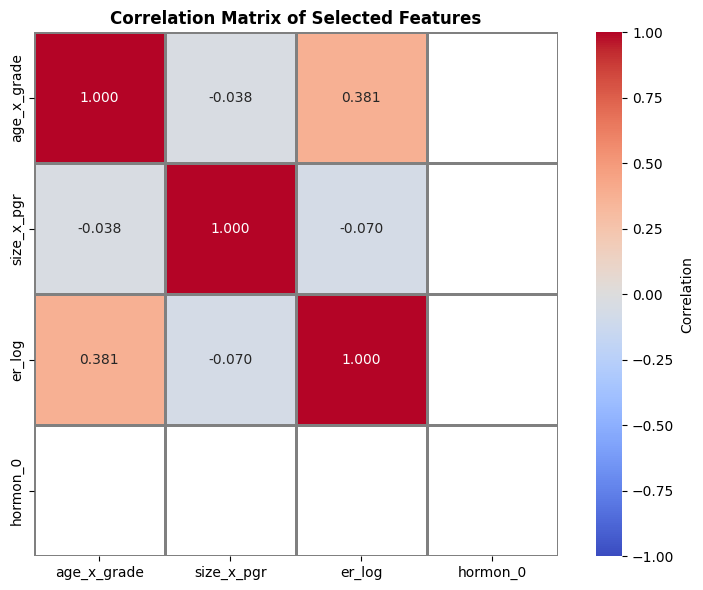

In [69]:
# --- CORRELATION & MULTICOLLINEARITY AMONG SELECTED FEATURES ---
print("=" * 80)
print("FEATURE INTERCORRELATION ANALYSIS (Selected Features)")
print("=" * 80 + "\n")

X_selected = X_test[best_features]
corr_matrix = X_selected.corr()

print("Correlation Matrix:")
print(corr_matrix.round(3).to_string())

# Identify highly correlated pairs
print("\n" + "-" * 80)
print("Highly Correlated Feature Pairs (|r| > 0.70):")
print("-" * 80)

high_corr_pairs = []
for i in range(len(best_features)):
    for j in range(i+1, len(best_features)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.70:
            high_corr_pairs.append({
                'Feature 1': best_features[i],
                'Feature 2': best_features[j],
                'Correlation': f"{corr_val:.4f}",
                'Redundancy Risk': 'HIGH' if abs(corr_val) > 0.85 else 'MODERATE'
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    print(high_corr_df.to_string(index=False))
    print("\n**ACTION:** For highly correlated pairs, keep the feature with:")
    print("  1. Higher univariate ROC-AUC")
    print("  2. Higher coefficient magnitude in the final model")
    print("  3. Greater clinical relevance")
else:
    print("No highly correlated pairs found. All features are relatively independent. ✓")

# Plot correlation heatmap
print("\n" + "=" * 80)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Correlation'}, ax=ax, vmin=-1, vmax=1,
            square=True, linewidths=1, linecolor='gray')
ax.set_title('Correlation Matrix of Selected Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


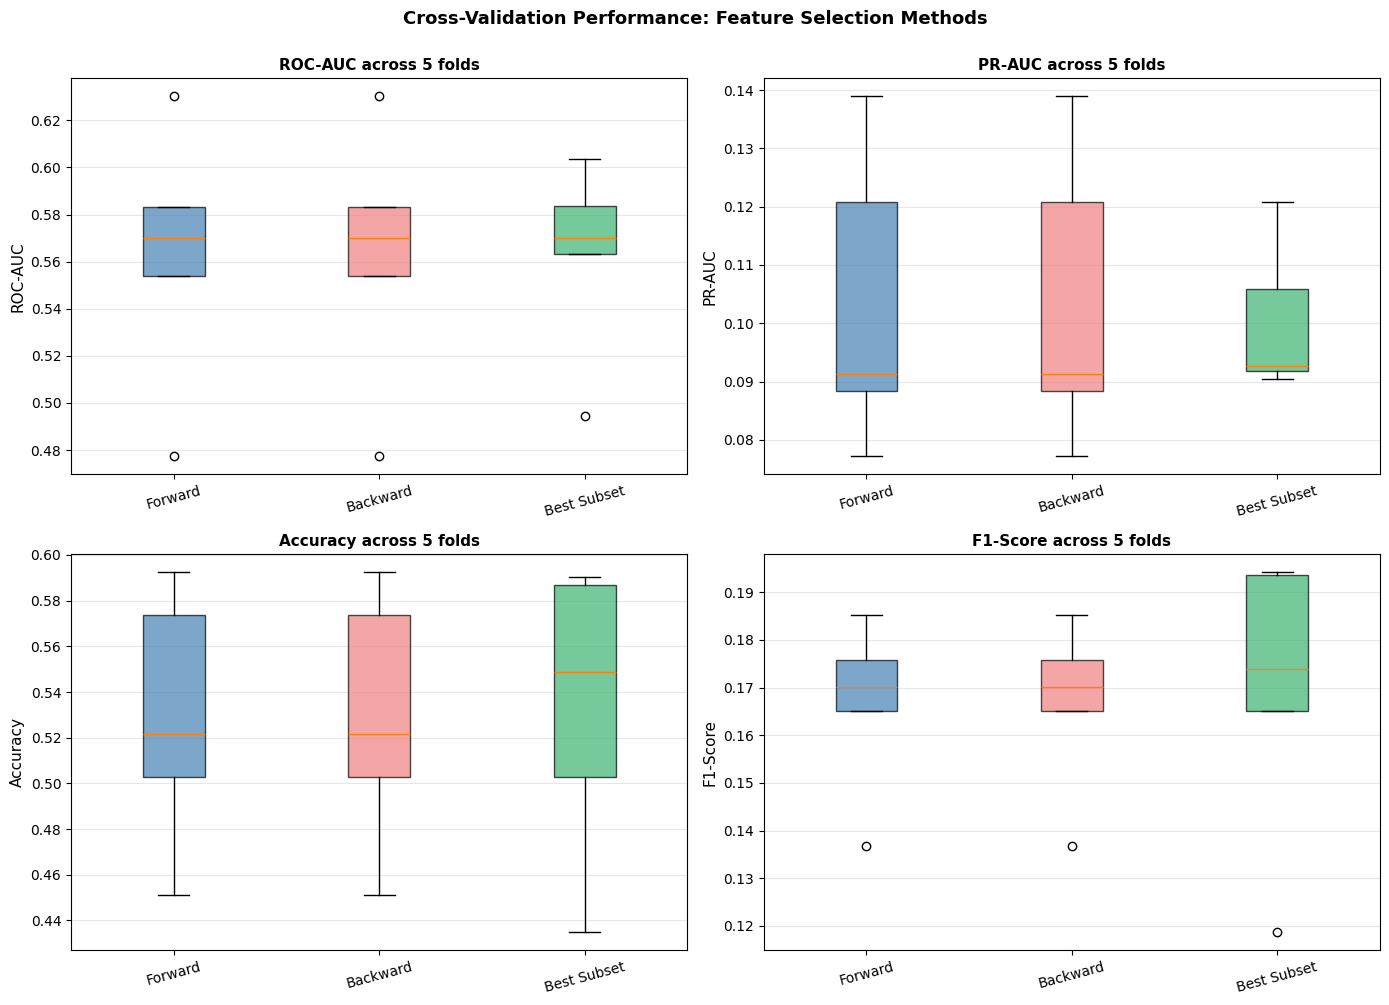

In [70]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['auc', 'pr_auc', 'accuracy', 'f1']
metric_labels = ['ROC-AUC', 'PR-AUC', 'Accuracy', 'F1-Score']
colors = ['steelblue', 'lightcoral', 'mediumseagreen']

for idx, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    ax = axes[idx // 2, idx % 2]
    
    box_data = []
    box_labels = []
    
    for method_name in ['forward', 'backward', 'best_subset']:
        if len(fold_results[method_name][metric]) > 0:
            box_data.append(fold_results[method_name][metric])
            box_labels.append(method_name.replace('_', ' ').title())
    
    if box_data:
        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(bp['boxes'], colors[:len(box_data)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax.set_ylabel(label, fontsize=11)
        ax.set_title(f'{label} across {n_folds} folds', fontsize=11, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)

plt.suptitle('Cross-Validation Performance: Feature Selection Methods', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

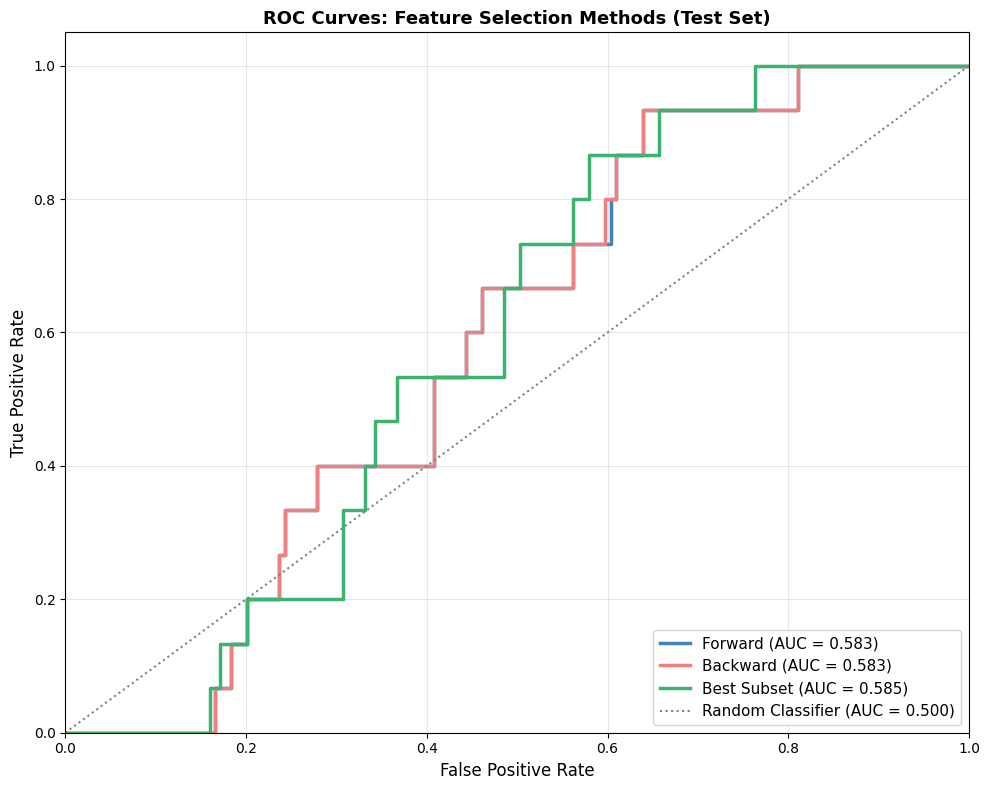


TEST SET PERFORMANCE SUMMARY

     Method  Features ROC-AUC PR-AUC Accuracy Precision Recall F1-Score
    Forward         2  0.5830 0.0884   0.5978    0.0845 0.4000   0.1395
   Backward         3  0.5834 0.0884   0.5978    0.0845 0.4000   0.1395
Best Subset         4  0.5850 0.0876   0.6250    0.1029 0.4667   0.1687



In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

colors_roc = {'forward': 'steelblue', 'backward': 'lightcoral', 'best_subset': 'mediumseagreen'}

# Plot ROC for each method
for method_name in ['forward', 'backward', 'best_subset']:
    y_prob = None
    
    if method_name == 'forward' and y_prob_fwd_test is not None:
        y_prob = y_prob_fwd_test
    elif method_name == 'backward' and y_prob_bwd_test is not None:
        y_prob = y_prob_bwd_test
    elif method_name == 'best_subset' and y_prob_best_test is not None:
        y_prob = y_prob_best_test
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = roc_auc_score(y_test, y_prob)
        
        ax.plot(fpr, tpr, 
               color=colors_roc[method_name],
               linewidth=2.5,
               label=f'{method_name.replace("_", " ").title()} (AUC = {roc_auc:.3f})')

# Plot random classifier
ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':', 
        label='Random Classifier (AUC = 0.500)')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves: Feature Selection Methods (Test Set)', 
             fontsize=13, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

# 6. Summary table with test set performance
print("\n" + "=" * 80)
print("TEST SET PERFORMANCE SUMMARY")
print("=" * 80 + "\n")

test_summary = []

for method_name in ['forward', 'backward', 'best_subset']:
    y_prob = None
    features = []
    
    if method_name == 'forward' and y_prob_fwd_test is not None:
        y_prob = y_prob_fwd_test
        features = fwd_features
    elif method_name == 'backward' and y_prob_bwd_test is not None:
        y_prob = y_prob_bwd_test
        features = bwd_features
    elif method_name == 'best_subset' and y_prob_best_test is not None:
        y_prob = y_prob_best_test
        features = best_features
    
    if y_prob is not None and len(features) > 0:
        y_pred = (y_prob >= 0.5).astype(int)
        
        # Calculate metrics
        test_auc = roc_auc_score(y_test, y_prob)
        test_acc = accuracy_score(y_test, y_pred)
        test_f1 = f1_score(y_test, y_pred)
        test_precision = precision_score(y_test, y_pred)
        test_recall = recall_score(y_test, y_pred)
        
        # PR-AUC
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        test_pr_auc = auc(recall_vals, precision_vals)
        
        test_summary.append({
            'Method': method_name.replace('_', ' ').title(),
            'Features': len(features),
            'ROC-AUC': f"{test_auc:.4f}",
            'PR-AUC': f"{test_pr_auc:.4f}",
            'Accuracy': f"{test_acc:.4f}",
            'Precision': f"{test_precision:.4f}",
            'Recall': f"{test_recall:.4f}",
            'F1-Score': f"{test_f1:.4f}"
        })

test_summary_df = pd.DataFrame(test_summary)
print(test_summary_df.to_string(index=False))
print("\n" + "=" * 80)


THRESHOLD: 0.426 - Sensitivity-Prioritized (≥90% Recall)
Performance Metrics:
  Sensitivity (Recall):  0.9333 (14/15)
  Specificity:           0.3432 (58/169)
  Precision:             0.1120 (14/125)
  F1-Score:              0.2000
  Accuracy:              0.3913

THRESHOLD: 0.444 - Youden's J Statistic (Balanced)
Performance Metrics:
  Sensitivity (Recall):  0.8667 (13/15)
  Specificity:           0.4201 (71/169)
  Precision:             0.1171 (13/111)
  F1-Score:              0.2063
  Accuracy:              0.4565

THRESHOLD: 0.444 - F1-Score (Equal Cost)
Performance Metrics:
  Sensitivity (Recall):  0.8667 (13/15)
  Specificity:           0.4201 (71/169)
  Precision:             0.1171 (13/111)
  F1-Score:              0.2063
  Accuracy:              0.4565


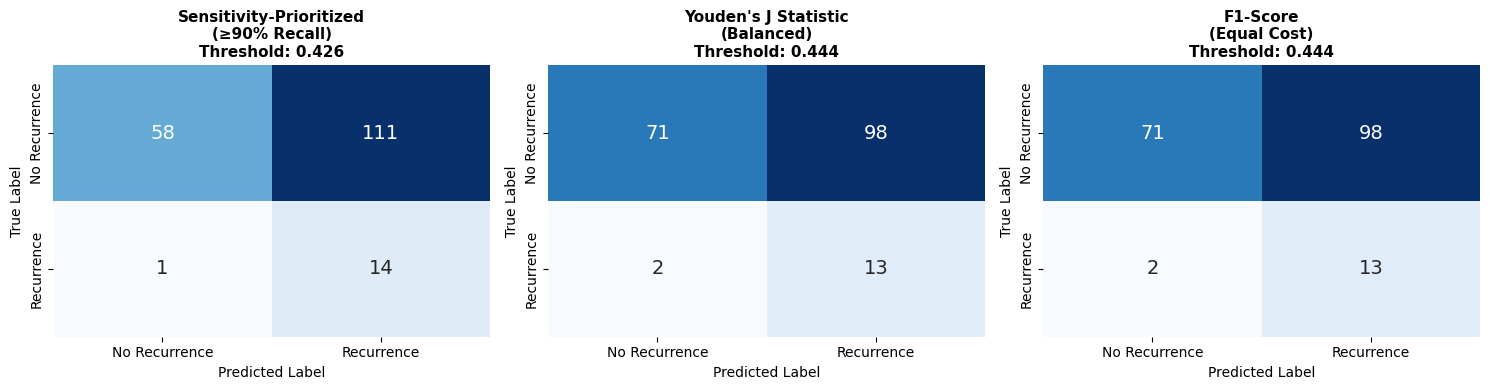

In [72]:
# --- Compute thresholds and their metrics ---

from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, accuracy_score, confusion_matrix

# Use y_prob_best_test as the final prediction probabilities for plotting
if y_prob_best_test is not None and len(y_prob_best_test) == len(y_test):
	y_prob_plot = y_prob_best_test
else:
	raise ValueError(
		"No valid prediction probabilities available for plotting. "
		"Please ensure y_prob_best_test is defined and matches y_test length."
	)

# ROC curve for sensitivity/specificity thresholds
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob_plot)
# Sensitivity-prioritized threshold (≥90% recall)
target_sensitivity = 0.90
sensitivity_idx = np.where(tpr >= target_sensitivity)[0]
if len(sensitivity_idx) > 0:
	idx = sensitivity_idx[0]
	sensitivity_threshold = roc_thresholds[idx]
	sensitivity_achieved = tpr[idx]
	specificity_achieved = 1 - fpr[idx]
else:
	# fallback: use highest sensitivity available
	idx = np.argmax(tpr)
	sensitivity_threshold = roc_thresholds[idx]
	sensitivity_achieved = tpr[idx]
	specificity_achieved = 1 - fpr[idx]

# Youden's J statistic threshold (maximizes sensitivity + specificity - 1)
j_scores = tpr - fpr
youden_idx = np.argmax(j_scores)
youdens_threshold = roc_thresholds[youden_idx]
youdens_sensitivity = tpr[youden_idx]
youdens_specificity = 1 - fpr[youden_idx]

# F1-optimal threshold (from precision-recall curve)
prec, rec, pr_thresholds = precision_recall_curve(y_test, y_prob_plot)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
f1_idx = np.argmax(f1_scores[:-1])  # last threshold is not used
f1_threshold = pr_thresholds[f1_idx]
f1_sensitivity = rec[f1_idx]
f1_specificity = None  # will compute below

# Compute specificity for F1 threshold
y_pred_f1 = (y_prob_plot >= f1_threshold).astype(int)
cm_f1 = confusion_matrix(y_test, y_pred_f1)
tn, fp, fn, tp = cm_f1.ravel()
f1_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

# --- Plot confusion matrices for the three threshold options ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

thresholds_to_plot = [
	('Sensitivity-Prioritized\n(≥90% Recall)', sensitivity_threshold, sensitivity_achieved, specificity_achieved),
	("Youden's J Statistic\n(Balanced)", youdens_threshold, youdens_sensitivity, youdens_specificity),
	('F1-Score\n(Equal Cost)', f1_threshold, f1_sensitivity, f1_specificity)
]

for idx, (title, threshold, sens, spec) in enumerate(thresholds_to_plot):
	y_pred_temp = (y_prob_plot >= threshold).astype(int)
	cm = confusion_matrix(y_test, y_pred_temp)
	tn, fp, fn, tp = cm.ravel()
	
	# Plot confusion matrix
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
				cbar=False, annot_kws={'size': 14})
	axes[idx].set_title(f'{title}\nThreshold: {threshold:.3f}', fontsize=11, fontweight='bold')
	axes[idx].set_ylabel('True Label', fontsize=10)
	axes[idx].set_xlabel('Predicted Label', fontsize=10)
	axes[idx].set_xticklabels(['No Recurrence', 'Recurrence'])
	axes[idx].set_yticklabels(['No Recurrence', 'Recurrence'])
	
	# Print metrics
	print(f"\n{'='*70}")
	print(f"THRESHOLD: {threshold:.3f} - {title.replace(chr(10), ' ')}")
	print(f"{'='*70}")
	print(f"Performance Metrics:")
	print(f"  Sensitivity (Recall):  {tp / (tp + fn):.4f} ({tp}/{tp + fn})")
	print(f"  Specificity:           {tn / (tn + fp):.4f} ({tn}/{tn + fp})")
	print(f"  Precision:             {tp / (tp + fp):.4f} ({tp}/{tp + fp})" if (tp + fp) > 0 else "  Precision:             N/A")
	print(f"  F1-Score:              {f1_score(y_test, y_pred_temp):.4f}")
	print(f"  Accuracy:              {accuracy_score(y_test, y_pred_temp):.4f}")

plt.tight_layout()
plt.show()


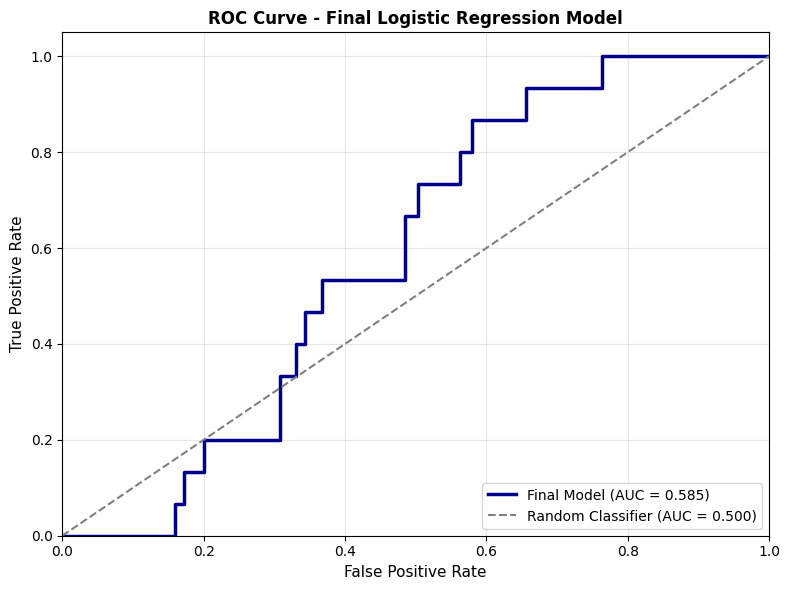

In [73]:
plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_prob_plot)
roc_auc = roc_auc_score(y_test, y_prob_plot)

plt.plot(fpr, tpr, color='darkblue', lw=2.5, label=f'Final Model (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle='--', label='Random Classifier (AUC = 0.500)')

plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.title('ROC Curve - Final Logistic Regression Model', fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [74]:
from sklearn.model_selection import GridSearchCV

print("=" * 80)
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("=" * 80 + "\n")
print("Note: Data is already balanced via undersampling, so no SMOTE needed.\n")

param_grid = {
    'penalty': ['l2', None],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['saga'],
    'class_weight': [None],  # No need for 'balanced' since data is already balanced
    'max_iter': [1000]
}

# Storage for tuned models
tuned_results = {}

# Hyperparameter tuning for each feature selection method
for method_name in ['forward', 'backward', 'best_subset']:
    print(f"\n{method_name.replace('_', ' ').title()}:")
    print("-" * 80)
    
    # Get features from the method
    if method_name == 'forward' and len(fwd_features) > 0:
        features = fwd_features
    elif method_name == 'backward' and len(bwd_features) > 0:
        features = bwd_features
    elif method_name == 'best_subset' and len(best_features) > 0:
        features = best_features
    
    print(f"  Features: {', '.join(features)}")
    
    # Prepare data with selected features using undersampled training data
    X_train_sel = X_train_undersampled[features].values
    X_test_sel = X_test[features].values
    
    # Add constant for statsmodels compatibility
    X_train_sel = sm.add_constant(X_train_sel)
    X_test_sel = sm.add_constant(X_test_sel)
    
    # Create classifier (no need for pipeline since data is already balanced)
    classifier = LogisticRegression(random_state=1234)

    grid_search = GridSearchCV(
        classifier,
        param_grid,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1234),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    grid_search.fit(X_train_sel, y_train_undersampled)
    
    # Best parameters
    print(f"\n  Best Parameters:")
    for param, value in grid_search.best_params_.items():
        print(f"    {param}: {value}")
    print(f"  Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    
    # Evaluate on test set
    best_model = grid_search.best_estimator_
    y_prob_tuned = best_model.predict_proba(X_test_sel)[:, 1]
    y_pred_tuned = best_model.predict(X_test_sel)
    
    # Calculate all metrics
    test_auc = roc_auc_score(y_test, y_prob_tuned)
    test_acc = accuracy_score(y_test, y_pred_tuned)
    test_f1 = f1_score(y_test, y_pred_tuned)
    test_precision = precision_score(y_test, y_pred_tuned)
    test_recall = recall_score(y_test, y_pred_tuned)
    
    # PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob_tuned)
    test_pr_auc = auc(recall_vals, precision_vals)
    
    print(f"\n  Test Set Performance:")
    print(f"    ROC-AUC: {test_auc:.4f}")
    print(f"    PR-AUC: {test_pr_auc:.4f}")
    print(f"    Accuracy: {test_acc:.4f}")
    print(f"    Precision: {test_precision:.4f}")
    print(f"    Recall: {test_recall:.4f}")
    print(f"    F1-Score: {test_f1:.4f}")
    
    # Store results
    tuned_results[method_name] = {
        'model': best_model,
        'features': features,
        'params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'y_prob': y_prob_tuned,
        'y_pred': y_pred_tuned,
        'metrics': {
            'roc_auc': test_auc,
            'pr_auc': test_pr_auc,
            'accuracy': test_acc,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        }
    }

print("\n" + "=" * 80)

HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Note: Data is already balanced via undersampling, so no SMOTE needed.


Forward:
--------------------------------------------------------------------------------
  Features: age_x_grade, er_log

  Best Parameters:
    C: 0.001
    class_weight: None
    max_iter: 1000
    penalty: l2
    solver: saga
  Best CV ROC-AUC: 0.6111

  Test Set Performance:
    ROC-AUC: 0.6304
    PR-AUC: 0.1003
    Accuracy: 0.5978
    Precision: 0.1067
    Recall: 0.5333
    F1-Score: 0.1778

Backward:
--------------------------------------------------------------------------------
  Features: age_x_grade, er_log, chemo_0

  Best Parameters:
    C: 0.001
    class_weight: None
    max_iter: 1000
    penalty: l2
    solver: saga
  Best CV ROC-AUC: 0.6111

  Test Set Performance:
    ROC-AUC: 0.6304
    PR-AUC: 0.1003
    Accuracy: 0.5978
    Precision: 0.1067
    Recall: 0.5333
    F1-Score: 0.1778

Best Subset:
--------------------------------------------------------

In [77]:
# Compare Original (no tuning) vs Tuned models
print("=" * 80)
print("MODEL COMPARISON: ORIGINAL (No Penalty) vs TUNED (GridSearchCV)")
print("=" * 80 + "\n")

# Train original models for comparison
original_results = {}

for method_name in ['forward', 'backward', 'best_subset']:
    # Get features
    if method_name == 'forward' and len(fwd_features) > 0:
        features = fwd_features
    elif method_name == 'backward' and len(bwd_features) > 0:
        features = bwd_features
    elif method_name == 'best_subset' and len(best_features) > 0:
        features = best_features
    else:
        continue
    
    # Train original model (no penalty, no tuning) on undersampled data
    X_train_sel = X_train_undersampled[features].values
    X_test_sel = X_test[features].values
    
    original_model = LogisticRegression(
        penalty=None,
        solver='lbfgs',
        max_iter=1000,
        random_state=1234
    )
    original_model.fit(X_train_sel, y_train_undersampled)
    
    y_prob_orig = original_model.predict_proba(X_test_sel)[:, 1]
    y_pred_orig = original_model.predict(X_test_sel)
    
    # Calculate metrics
    orig_auc = roc_auc_score(y_test, y_prob_orig)
    orig_acc = accuracy_score(y_test, y_pred_orig)
    orig_f1 = f1_score(y_test, y_pred_orig)
    orig_precision = precision_score(y_test, y_pred_orig)
    orig_recall = recall_score(y_test, y_pred_orig)
    
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob_orig)
    orig_pr_auc = auc(recall_vals, precision_vals)
    
    original_results[method_name] = {
        'y_prob': y_prob_orig,
        'y_pred': y_pred_orig,
        'metrics': {
            'roc_auc': orig_auc,
            'pr_auc': orig_pr_auc,
            'accuracy': orig_acc,
            'precision': orig_precision,
            'recall': orig_recall,
            'f1': orig_f1
        }
    }

# Create comparison table
comparison_data = []
for method_name in tuned_results.keys():
    if method_name in original_results:
        orig = original_results[method_name]['metrics']
        tuned = tuned_results[method_name]['metrics']
        
        comparison_data.append({
            'Method': method_name.replace('_', ' ').title(),
            'Model': 'Original',
            'ROC-AUC': f"{orig['roc_auc']:.4f}",
            'PR-AUC': f"{orig['pr_auc']:.4f}",
            'Accuracy': f"{orig['accuracy']:.4f}",
            'Precision': f"{orig['precision']:.4f}",
            'Recall': f"{orig['recall']:.4f}",
            'F1-Score': f"{orig['f1']:.4f}"
        })
        
        comparison_data.append({
            'Method': method_name.replace('_', ' ').title(),
            'Model': 'Tuned',
            'ROC-AUC': f"{tuned['roc_auc']:.4f}",
            'PR-AUC': f"{tuned['pr_auc']:.4f}",
            'Accuracy': f"{tuned['accuracy']:.4f}",
            'Precision': f"{tuned['precision']:.4f}",
            'Recall': f"{tuned['recall']:.4f}",
            'F1-Score': f"{tuned['f1']:.4f}"
        })
        
        # Calculate improvement
        improvement = {
            'Method': method_name.replace('_', ' ').title(),
            'Model': 'Δ (Improvement)',
            'ROC-AUC': f"{tuned['roc_auc'] - orig['roc_auc']:+.4f}",
            'PR-AUC': f"{tuned['pr_auc'] - orig['pr_auc']:+.4f}",
            'Accuracy': f"{tuned['accuracy'] - orig['accuracy']:+.4f}",
            'Precision': f"{tuned['precision'] - orig['precision']:+.4f}",
            'Recall': f"{tuned['recall'] - orig['recall']:+.4f}",
            'F1-Score': f"{tuned['f1'] - orig['f1']:+.4f}"
        }
        comparison_data.append(improvement)
        comparison_data.append({'Method': '', 'Model': '', 'ROC-AUC': '', 'PR-AUC': '', 'Accuracy': '', 'Precision': '', 'Recall': '', 'F1-Score': ''})

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Find best overall model
print("\n" + "=" * 80)
print("BEST TUNED MODEL")
print("=" * 80)

best_tuned_method = max(tuned_results.keys(), 
                        key=lambda m: tuned_results[m]['metrics']['roc_auc'])

print(f"\nMethod: {best_tuned_method.replace('_', ' ').title()}")
print(f"Best Parameters: {tuned_results[best_tuned_method]['params']}")
print(f"Features: {', '.join(tuned_results[best_tuned_method]['features'])}")
print(f"\nTest Performance:")
for metric, value in tuned_results[best_tuned_method]['metrics'].items():
    print(f"  {metric.upper()}: {value:.4f}")

MODEL COMPARISON: ORIGINAL (No Penalty) vs TUNED (GridSearchCV)

     Method           Model ROC-AUC  PR-AUC Accuracy Precision  Recall F1-Score
    Forward        Original  0.5830  0.0884   0.5978    0.0845  0.4000   0.1395
    Forward           Tuned  0.6304  0.1003   0.5978    0.1067  0.5333   0.1778
    Forward Δ (Improvement) +0.0473 +0.0119  +0.0000   +0.0222 +0.1333  +0.0382
                                                                               
   Backward        Original  0.5834  0.0884   0.5978    0.0845  0.4000   0.1395
   Backward           Tuned  0.6304  0.1003   0.5978    0.1067  0.5333   0.1778
   Backward Δ (Improvement) +0.0469 +0.0119  +0.0000   +0.0222 +0.1333  +0.0382
                                                                               
Best Subset        Original  0.5854  0.0877   0.6250    0.1029  0.4667   0.1687
Best Subset           Tuned  0.6059  0.0916   0.5924    0.1154  0.6000   0.1935
Best Subset Δ (Improvement) +0.0205 +0.0040  -0.0326   

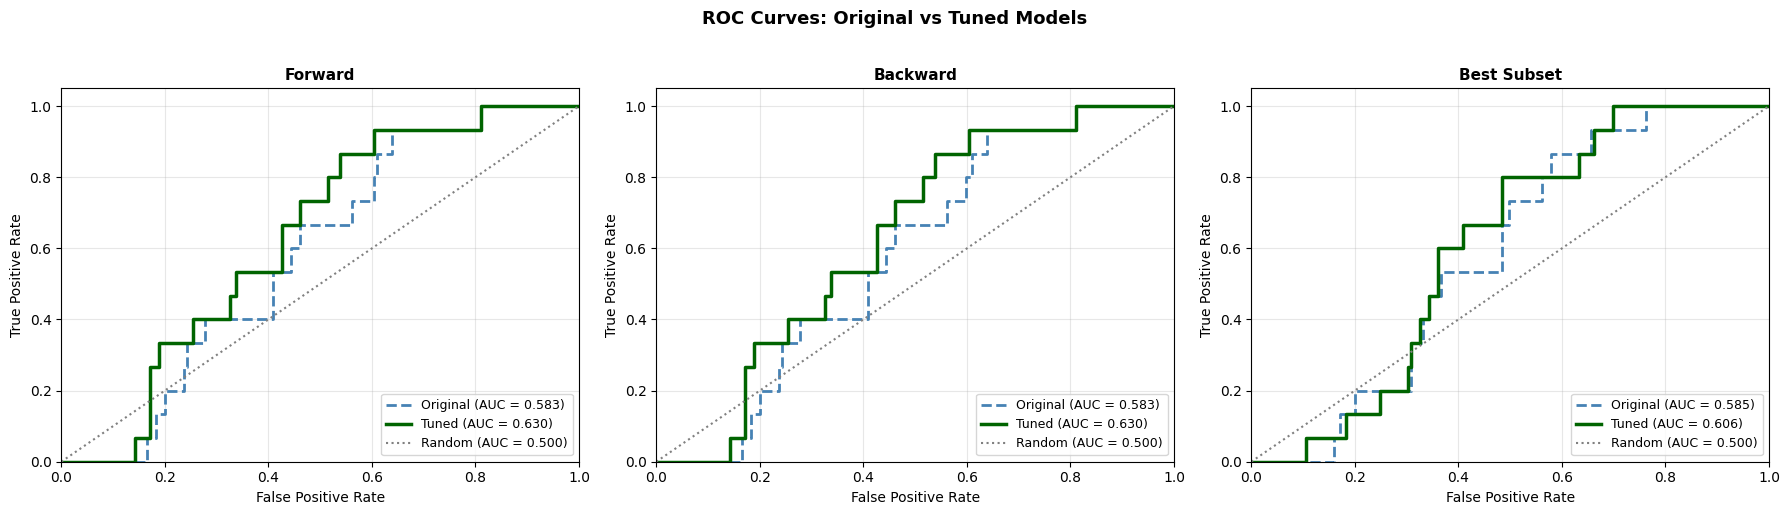

In [78]:
# Visualize comparison: ROC curves for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, method_name in enumerate(['forward', 'backward', 'best_subset']):
    if method_name not in tuned_results:
        continue
    
    ax = axes[idx]
    
    # Original model ROC
    if method_name in original_results:
        fpr_orig, tpr_orig, _ = roc_curve(y_test, original_results[method_name]['y_prob'])
        auc_orig = original_results[method_name]['metrics']['roc_auc']
        ax.plot(fpr_orig, tpr_orig, color='steelblue', lw=2, 
                label=f'Original (AUC = {auc_orig:.3f})', linestyle='--')
    
    # Tuned model ROC
    fpr_tuned, tpr_tuned, _ = roc_curve(y_test, tuned_results[method_name]['y_prob'])
    auc_tuned = tuned_results[method_name]['metrics']['roc_auc']
    ax.plot(fpr_tuned, tpr_tuned, color='darkgreen', lw=2.5, 
            label=f'Tuned (AUC = {auc_tuned:.3f})')
    
    # Random classifier
    ax.plot([0, 1], [0, 1], color='gray', lw=1.5, linestyle=':', 
            label='Random (AUC = 0.500)')
    
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'{method_name.replace("_", " ").title()}', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

plt.suptitle('ROC Curves: Original vs Tuned Models', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

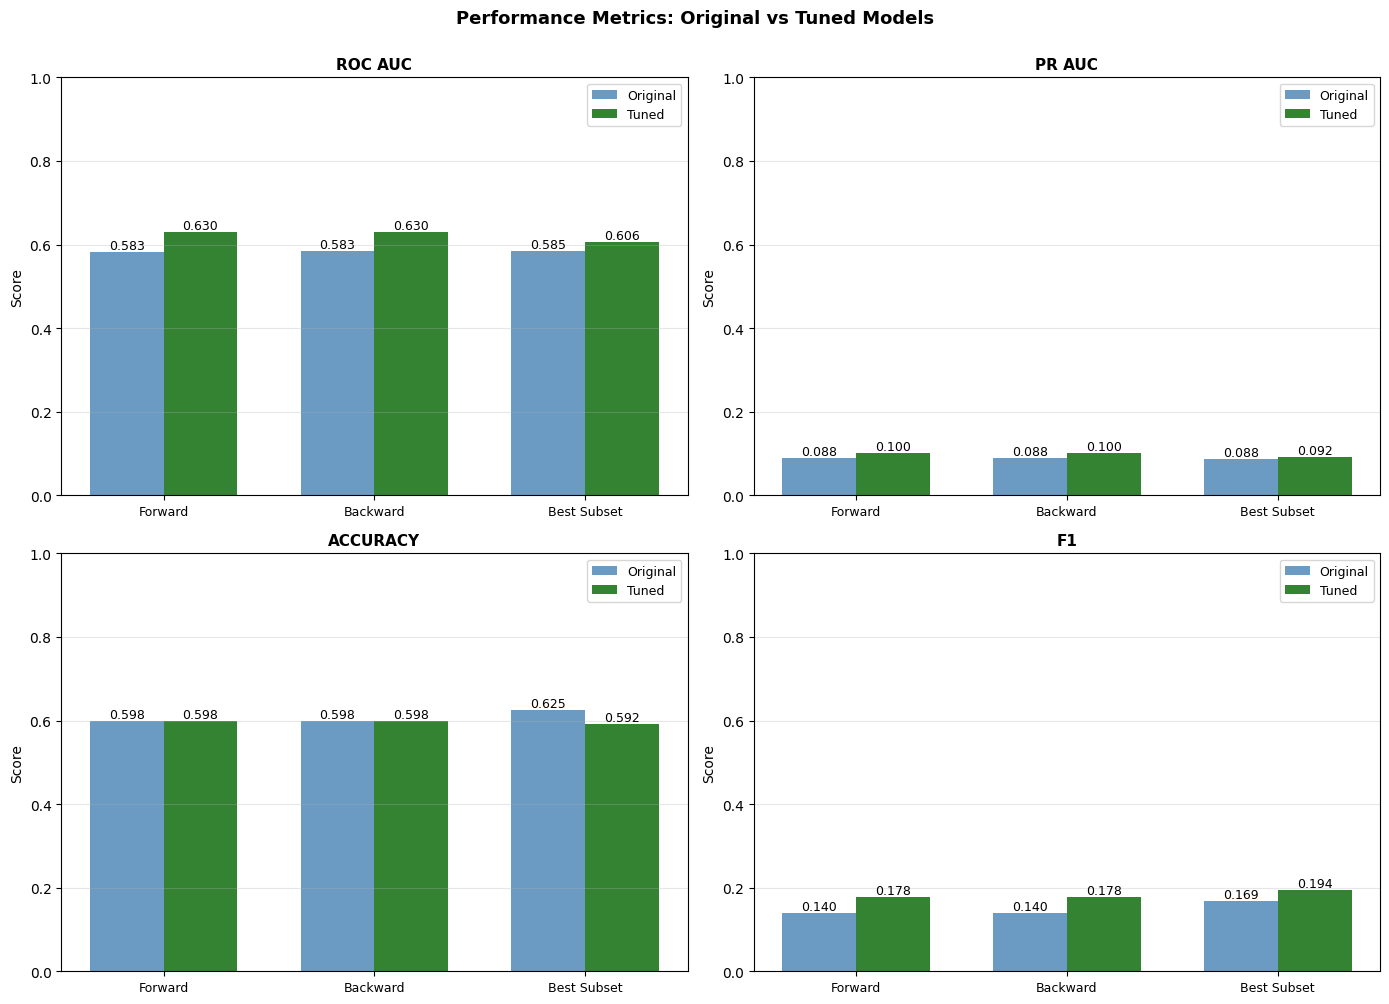

In [79]:
# Bar chart comparing metrics across all models
metrics_list = ['roc_auc', 'pr_auc', 'accuracy', 'f1']
methods = list(tuned_results.keys())

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_list):
    ax = axes[idx]
    
    x = np.arange(len(methods))
    width = 0.35
    
    original_scores = [original_results[m]['metrics'][metric] for m in methods if m in original_results]
    tuned_scores = [tuned_results[m]['metrics'][metric] for m in methods if m in tuned_results]
    
    bars1 = ax.bar(x - width/2, original_scores, width, label='Original', color='steelblue', alpha=0.8)
    bars2 = ax.bar(x + width/2, tuned_scores, width, label='Tuned', color='darkgreen', alpha=0.8)
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel('Score', fontsize=10)
    ax.set_title(metric.replace('_', ' ').upper(), fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in methods], fontsize=9)
    ax.legend(fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Performance Metrics: Original vs Tuned Models', fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

DETAILED EVALUATION: BEST TUNED MODEL (Forward)

Classification Report:
               precision    recall  f1-score   support

No Recurrence      0.936     0.604     0.734       169
   Recurrence      0.107     0.533     0.178        15

     accuracy                          0.598       184
    macro avg      0.521     0.568     0.456       184
 weighted avg      0.868     0.598     0.688       184


Confusion Matrix:
[[102  67]
 [  7   8]]


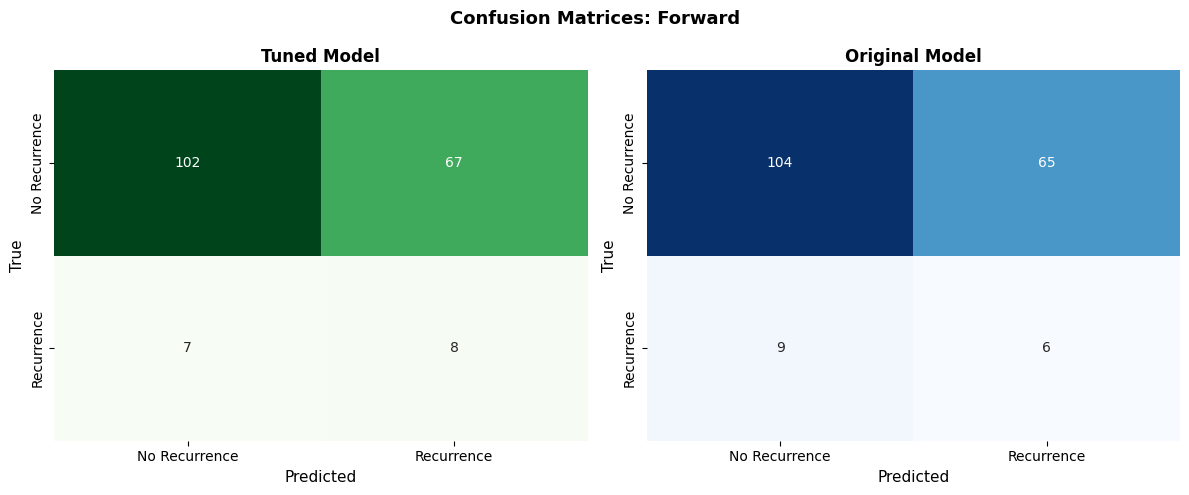

In [80]:
# Detailed classification report and confusion matrix for best tuned model
print("=" * 80)
print(f"DETAILED EVALUATION: BEST TUNED MODEL ({best_tuned_method.replace('_', ' ').title()})")
print("=" * 80 + "\n")

best_y_pred = tuned_results[best_tuned_method]['y_pred']
best_y_prob = tuned_results[best_tuned_method]['y_prob']

print("Classification Report:")
print(classification_report(y_test, best_y_pred, target_names=['No Recurrence', 'Recurrence'], digits=3))

cm_tuned = confusion_matrix(y_test, best_y_pred)
print("\nConfusion Matrix:")
print(cm_tuned)

# Plot confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Tuned model confusion matrix
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', cbar=False, ax=ax1,
            xticklabels=['No Recurrence', 'Recurrence'],
            yticklabels=['No Recurrence', 'Recurrence'])
ax1.set_xlabel('Predicted', fontsize=11)
ax1.set_ylabel('True', fontsize=11)
ax1.set_title('Tuned Model', fontsize=12, fontweight='bold')

# Original model confusion matrix for comparison
if best_tuned_method in original_results:
    cm_orig = confusion_matrix(y_test, original_results[best_tuned_method]['y_pred'])
    sns.heatmap(cm_orig, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax2,
                xticklabels=['No Recurrence', 'Recurrence'],
                yticklabels=['No Recurrence', 'Recurrence'])
    ax2.set_xlabel('Predicted', fontsize=11)
    ax2.set_ylabel('True', fontsize=11)
    ax2.set_title('Original Model', fontsize=12, fontweight='bold')

plt.suptitle(f'Confusion Matrices: {best_tuned_method.replace("_", " ").title()}', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()